## Importation

In [4]:
import pickle
import pandas as pd # data science library to manipulate data
import numpy as np # mathematical library to manipulate arrays and matrices
import matplotlib.pyplot as plt # visualization library
from sklearn.feature_selection import SelectKBest # selection method
from sklearn.feature_selection import mutual_info_regression,f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import  linear_model

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import  metrics
from sklearn.neural_network import MLPRegressor


## Clean&Merge Data

In [5]:
# regions=['Auvergne-Rhône-Alpes']
regions=['Auvergne-Rhône-Alpes','Bourgogne-Franche-Comté','Bretagne','Centre-Val-de-Loire','Grand-Est','Hauts-de-France','Ile-de-France','Normandie','Nouvelle-Aquitaine','Occitanie','PACA','Pays-de-la-Loire']


### Meteo Data

In [6]:
df_meteo={}

for region in regions:
    df_meteo[region]=pd.read_csv('meteo_data/{}.csv'.format(region), sep=';') # loads a csv file into a dataframe
    df_meteo[region]['Date']=df_meteo[region]['Date'].str.slice(0,19)
    df_meteo[region]['Date']=pd.to_datetime(df_meteo[region]['Date'], format='%Y-%m-%dT%H:%M:%S')

    df_meteo[region] = df_meteo[region].set_index ('Date', drop = True) # put the date in index
    new_hours = {1: 0, 4: 3, 7: 6, 10: 9, 13: 12, 16: 15, 19: 18, 22: 21}
    new_index = df_meteo[region].index.map(lambda x: x.replace(hour=new_hours.get(x.hour, x.hour)))
    df_meteo[region].index = new_index
    df_meteo[region].sort_values('Date', inplace=True) # sort the values by the date

# df_meteo[region].head()

C:\Users\augus\AppData\Local\Temp\ipykernel_25100\764701505.py:4: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meteo[region]=pd.read_csv('meteo_data/{}.csv'.format(region), sep=';') # loads a csv file into a dataframe


### Power Data

In [7]:
df_power={}
# regions=['Auvergne-Rhône-Alpes']
for region in regions:
    # Import data form the tree csv
    df1=pd.read_csv('power_data/eCO2mix_RTE_{}_Annuel-Definitif_2020/eCO2mix_RTE_{}_Annuel-Definitif_2020.xls'.format(region, region), delimiter='\t',encoding='latin-1')    
    df2=pd.read_csv('power_data/eCO2mix_RTE_{}_En-cours-Consolide/eCO2mix_RTE_{}_En-cours-Consolide.xls'.format(region, region), delimiter='\t',encoding='latin-1')
    df3=pd.read_csv('power_data/eCO2mix_RTE_{}_En-cours-TR/eCO2mix_RTE_{}_En-cours-TR.xls'.format(region, region), delimiter='\t',encoding='latin-1')
    
    # Concatenate the 3 dataframe
    df_power[region] = pd.concat([df1, df2, df3], ignore_index=True) 

    # Put Date in datetime object and in index
    datetime_str = df_power[region]['Date'] + ' ' + df_power[region]['Heures']  
    df_power[region]['Date'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M')
    df_power[region] = df_power[region].drop(columns=['Heures'])
    df_power[region] = df_power[region].set_index ('Date', drop = True) # put the date in index
    df_power[region].sort_values('Date', inplace=True) # sort the values by the date
    df_power[region] = df_power[region].iloc[:-3]

# df_power[region].head()

C:\Users\augus\AppData\Local\Temp\ipykernel_25100\3128813564.py:6: DtypeWarning: Columns (12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('power_data/eCO2mix_RTE_{}_En-cours-Consolide/eCO2mix_RTE_{}_En-cours-Consolide.xls'.format(region, region), delimiter='\t',encoding='latin-1')
C:\Users\augus\AppData\Local\Temp\ipykernel_25100\3128813564.py:7: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,16,18,20,25,26,28,30,32,37,38,40,44,47,51,54,55,56,57,58,59,60,61,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df3=pd.read_csv('power_data/eCO2mix_RTE_{}_En-cours-TR/eCO2mix_RTE_{}_En-cours-TR.xls'.format(region, region), delimiter='\t',encoding='latin-1')
C:\Users\augus\AppData\Local\Temp\ipykernel_25100\3128813564.py:6: DtypeWarning: Columns (12,13,14,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv('power_data/eCO2mix_RTE_{}_En-cours-Consol

### Merge Power Data and Meteo Data and dropna

In [8]:
df_merged={}
# regions=['Auvergne-Rhône-Alpes']
for region in regions:
    # df_merged[region]=pd.merge(df_power[region], df_meteo[region], left_index=True, right_index=True, how='outer') 

    df_merged[region] = pd.merge(df_power[region], df_meteo[region], left_index=True, right_index=True, how='inner')
    df_merged[region] = df_merged[region][(df_merged[region]['Consommation'] != 'ND') ]#& (df_merged[region]['colonne2'] != 'ND')]
    df_merged[region].replace({'-': 0}, inplace=True)
    list_colonnes = ['Consommation','Thermique','Nucléaire','Eolien','Solaire','Hydraulique','Pompage','Bioénergies']
    for col in list_colonnes:
        df_merged[region] = df_merged[region][(df_merged[region][col] != 'ND')]

# df_merged[region].head()

# df_merged[region].to_csv('merged.csv', index=True)

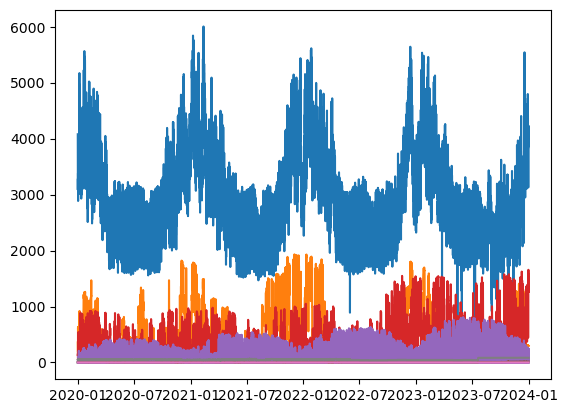

In [9]:
for col in list_colonnes:
    plt.plot(df_merged[region].index, df_merged[region][col])

### Outliers removal

## Feature Selection for consumption prevision

In [10]:
# regions=['Auvergne-Rhône-Alpes']
X_cons={}
Y_cons={}
Z_cons={}
df_merged2=df_merged.copy()
for region in regions:
    df_merged2[region]['Consommation-1']=df_merged2[region]['Consommation'].shift(1)
    df_merged2[region] = df_merged2[region].drop(df_merged2[region].index[0])

    # Only keep the columns that are interesting
    list_variables=[2,149]+list(range(3,149))
    variable_to_delete=[1,78,79,80,83,84,85,86,88,89,99,100,101,103,104]+list(range(10,69))+list(range(91,98))+list(range(107,131))+list(range(132,148))
    list_variables=[k for k in list_variables if k not in variable_to_delete]

    df_merged2[region]=df_merged2[region].iloc[:, list_variables]
    df_merged2[region]=df_merged2[region].dropna()
    df_merged2[region]['Hour'] = df_merged2[region].index.hour

    # Define input and outputs
    Z_cons[region]=df_merged2[region].values
    Y_cons[region]=Z_cons[region][:,0]
    Y_cons[region]=np.array([float(k) for k in Y_cons[region]])
    X_cons[region]=Z_cons[region][:,[1]+list(range(9,len(Z_cons[region][1])))]


# print(df_merged2[region].columns)
# print(df_merged2[region].iloc[:,[1]+list(range(9,len(Z1[region][1])))].columns)
# print(Z1[region][:,[1]+list(range(9,len(Z1[region][1])))])
# df_merged2[region].head()
# df_merged2[region].to_csv('merged2.csv', index=True)

### Filter Methods

In [11]:
# # regions=['Auvergne-Rhône-Alpes']

# for region in regions:
#     features=SelectKBest(score_func=mutual_info_regression)
#     fit=features.fit(X_cons[region],Y_cons[region]) #calculates the scores using the score_function f_regression of the features
#     # print(fit.scores_)
#     plt.bar([i for i in range(len(fit.scores_))], fit.scores_)
#     plt.title(region)
#     plt.show()

#     # liste=df_merged2[region].iloc[:,[1]+list(range(9,len(Z1[region][1])))].columns
#     # plt.bar(liste, fit.scores_)


### Embedded methods

In [12]:
# # regions=['Auvergne-Rhône-Alpes']

# for region in regions:
#     model = RandomForestRegressor()
#     model.fit(X_cons[region],Y_cons[region])
#     # print(model.feature_importances_)
#     # plt.bar([i for i in range(len(model.feature_importances_))], model.feature_importances_)
#     # plt.title(region)
#     # plt.show()

## Train Model for consumption prevision

### Separation into datasets and normalization

In [13]:
result={}
features_names_cons={}
# df_data = df_merged5.copy()
X2_cons={}
X2_train_cons={}
X2_test_cons={}

Y_train_cons={}
Y_test_cons={}

ss_X_cons={}
ss_Y_cons={}

X2_train_ss_cons={}
X2_test_ss_cons={}
Y_train_ss_cons={}

for region in regions:
    X2_cons[region]=X_cons[region][:,[0,19,18,7]]
    features_names_cons[region]=df_merged2[region].columns[[1]+list(range(9,len(Z_cons[region][1])))][[0,19,18,7]]

    #by default, it chooses randomly 75% of the data for training and 25% for testing  
    X2_train_cons[region], X2_test_cons[region], Y_train_cons[region], Y_test_cons[region] = train_test_split(X2_cons[region],Y_cons[region])
    ss_X_cons[region] = StandardScaler()
    ss_Y_cons[region] = StandardScaler()

    # Normalization of the training datas
    X2_train_ss_cons[region] = ss_X_cons[region].fit_transform(X2_train_cons[region])  
    Y_train_ss_cons[region] = ss_Y_cons[region].fit_transform(Y_train_cons[region].reshape(-1,1))

    # Normalization of the test datas
    X2_test_ss_cons[region] = ss_X_cons[region].transform(X2_test_cons[region] )

# x a partir de z [1]+list(range(9,len(Z_cons[region][1])))
# x2 a partir de x [0,19,18,7]

# print(len([k for k in Y_cons[region] if isinstance(k, str)]))

# print([k for k in range(len(Y_cons[region])) if isinstance(Y_cons[region][k], str)])
print(features_names_cons)

{'Auvergne-Rhône-Alpes': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C)',
       'Point de rosée'],
      dtype='object'), 'Bourgogne-Franche-Comté': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C)',
       'Point de rosée'],
      dtype='object'), 'Bretagne': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C)',
       'Point de rosée'],
      dtype='object'), 'Centre-Val-de-Loire': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C)',
       'Point de rosée'],
      dtype='object'), 'Grand-Est': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C)',
       'Point de rosée'],
      dtype='object'), 'Hauts-de-France': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C)',
       'Point de rosée'],
      dtype='object'), 'Ile-de-France': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C)',
       'Point de rosée'],
      dtype='object'), 'Normandie': Index(['Consommation-1', 'mois_de_l_annee', 'Température (°C

### Linear Regression

In [14]:
# regrLR_cons={}

# def LR_cons(region):
#     # Create linear regression object
#     regr = linear_model.LinearRegression()

#     # Train the model using the training sets
#     regr.fit(X2_train_ss_cons[region],Y_train_ss_cons[region])

#     # Make predictions using the testing set
#     y_pred_LR = regr.predict(X2_test_ss_cons[region])
#     y_pred_LR = ss_Y_cons[region].inverse_transform(y_pred_LR.reshape(-1,1))

#     # plt.plot(Y_test_cons[region]) #[1:200]
#     # plt.plot(y_pred_LR) #[1:200]
#     # plt.show()
#     # plt.scatter(Y_test_cons[region],y_pred_LR)
#     # print(y_pred_LR.reshape(1,-1)[0])

#     #Evaluate errors
#     MAE_LR=metrics.mean_absolute_error(Y_test_cons[region],y_pred_LR) 
#     MBE_LR=np.mean(Y_test_cons[region]-y_pred_LR) #here we calculate MBE
#     MSE_LR=metrics.mean_squared_error(Y_test_cons[region],y_pred_LR)  
#     RMSE_LR= np.sqrt(metrics.mean_squared_error(Y_test_cons[region],y_pred_LR))
#     cvRMSE_LR=RMSE_LR/np.mean(Y_test_cons[region])
#     NMBE_LR=MBE_LR/np.mean(Y_test_cons[region])

#     result[region+'LRcons']=[MAE_LR, MBE_LR,MSE_LR, RMSE_LR,cvRMSE_LR,NMBE_LR]

#     # print(MAE_LR, MBE_LR,MSE_LR, RMSE_LR,cvRMSE_LR,NMBE_LR)
#     return regr
# for region in regions:
#     regrLR_cons[region]=LR_cons(region)

### Random Forest

In [15]:
regrRF_cons={}

def RF_cons(region,parameter={}):    
    RF_model = RandomForestRegressor(**parameter)
    #RF_model = RandomForestRegressor()
    RF_model.fit(X2_train_ss_cons[region],Y_train_ss_cons[region])
    y_pred_RF = RF_model.predict(X2_test_ss_cons[region])
    y_pred_RF = ss_Y_cons[region].inverse_transform(y_pred_RF.reshape(-1,1))

    # plt.plot(Y_test_cons[region][1:200])
    # plt.plot(y_pred_RF[1:200])
    # plt.show()
    # plt.scatter(Y_test_cons[region],y_pred_RF)

    #Evaluate errors
    MAE_RF=metrics.mean_absolute_error(Y_test_cons[region],y_pred_RF) 
    MBE_RF=np.mean(Y_test_cons[region]-y_pred_RF) #here we calculate MBE
    MSE_RF=metrics.mean_squared_error(Y_test_cons[region],y_pred_RF)  
    RMSE_RF= np.sqrt(metrics.mean_squared_error(Y_test_cons[region],y_pred_RF))
    cvRMSE_RF=RMSE_RF/np.mean(Y_test_cons[region])
    NMBE_RF=MBE_RF/np.mean(Y_test_cons[region])

    result[region+'RFcons']=[MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF]

    print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)
    return RF_model,[MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF]

# for region in regions:
#     regrRF_cons[region]=RF_cons(region)

### Neural Network

In [16]:
# regrNN_cons={}

# def NN_cons(region,parameter={}):
#     NN_model = MLPRegressor(**parameter)

#     NN_model.fit(X2_train_ss_cons[region],Y_train_ss_cons[region])
#     y_pred_NN = NN_model.predict(X2_test_ss_cons[region])
#     # y_test_NN = y2_test.reshape(-1,1)#It is just one column we have to reshape, otherwise its a line
#     y_pred_NN = ss_Y_cons[region].inverse_transform(y_pred_NN.reshape(-1,1))

#     plt.plot(Y_test_cons[region][1:200])
#     plt.plot(y_pred_NN[1:200])
#     plt.show()
#     plt.scatter(Y_test_cons[region],y_pred_NN)

#     MAE_NN=metrics.mean_absolute_error(Y_test_cons[region],y_pred_NN)
#     MBE_NN=np.mean(Y_test_cons[region]-y_pred_NN)
#     MSE_NN=metrics.mean_squared_error(Y_test_cons[region],y_pred_NN)  
#     RMSE_NN= np.sqrt(metrics.mean_squared_error(Y_test_cons[region],y_pred_NN))
#     cvRMSE_NN=RMSE_NN/np.mean(Y_test_cons[region])
#     NMBE_NN=MBE_NN/np.mean(Y_test_cons[region])

#     result[region+'NNcons']=[MAE_NN,MBE_NN,MSE_NN,RMSE_NN,cvRMSE_NN,NMBE_NN]

#     # print(MAE_NN,MBE_NN,MSE_NN,RMSE_NN,cvRMSE_NN,NMBE_NN)
#     return NN_model

# for region in regions:
#     regrNN_cons[region]=NN_cons(region)

### Plot of the metrics

In [17]:
#Delete the worst models :
# del result['AR']

# plt.plot(result.keys(), [result[k][0] for k in result.keys()], marker='o', linestyle='-')
# plt.show()
# plt.plot(result.keys(), [result[k][3] for k in result.keys()], marker='o', linestyle='-')
# plt.plot(result.keys(), [result[k][1] for k in result.keys()], marker='o', linestyle='-')
# plt.plot(result.keys(), [result[k][2] for k in result.keys()], marker='o', linestyle='-')

### Optimization of the parameters for Random Forest

In [18]:
# paramsRF_cons={}
# for region in regions:
#     paramsRF_cons[region] = {
#         'n_estimators': 500,
#         'max_depth': 40,
#         'min_samples_split': 80,
#         'min_samples_leaf': 10
#     }

# # print(RF_cons('Auvergne-Rhône-Alpes',paramsRF_cons[region])[1])

## Feature Selection for production prevision

In [19]:
# regions=['Auvergne-Rhône-Alpes']
X_prod={}
Y_prod={}
Z_prod={}
df_merged3=df_merged.copy()
for region in regions:
    productions=['Thermique','Nucléaire','Eolien','Solaire','Hydraulique','Pompage','Bioénergies']
    for production in productions:
        df_merged3[region][production+'-1']=df_merged3[region][production].shift(1)
    df_merged3[region] = df_merged3[region].drop(df_merged3[region].index[0])

    # Only keep the columns that are interesting
    list_variables=[2,149]+list(range(3,157))
    variable_to_delete=[1,78,79,80,83,84,85,86,88,89,99,100,101,103,104]+list(range(10,69))+list(range(91,98))+list(range(107,131))+list(range(132,148))
    list_variables=[k for k in list_variables if k not in variable_to_delete]

    df_merged3[region]=df_merged3[region].iloc[:, list_variables]
    df_merged3[region]=df_merged3[region].dropna()
    df_merged3[region]['Hour'] = df_merged3[region].index.hour

    # Define input and outputs
    Z_prod[region]=df_merged3[region].values
    Y_prod[region]=Z_prod[region][:,[2,3,4,5,6,7,8]]
    X_prod[region]=Z_prod[region][:,list(range(29,36))+list(range(9,28))+[36]]

    # Put all values in float
    for k in range(Y_prod[region].shape[0]):
        for i in range(Y_prod[region].shape[1]):
            Y_prod[region][k][i]=float(Y_prod[region][k,i])

    for k in range(X_prod[region].shape[0]):
        for i in range(X_prod[region].shape[1]):
            X_prod[region][k][i]=float(X_prod[region][k,i])


# print(df_merged3[region].columns)
# print(df_merged3[region].iloc[:,[1]+list(range(9,len(Z1[region][1])))].columns)
# df_merged3[region].to_csv('merged3.csv', index=True)
# print(X_prod[region])
# print(X_prod[region].shape)
# print(Y_prod[region].shape)
# df_merged3[region].head()

# print(df_merged3['Auvergne-Rhône-Alpes'].columns)


### Filter Methods

In [20]:
# # regions=['Auvergne-Rhône-Alpes']
# from sklearn.feature_selection import SelectPercentile
# for region in regions:
#     # features=SelectKBest(score_func=mutual_info_regression)
#     features = SelectPercentile(score_func=mutual_info_regression, percentile=50)

#     fit=features.fit(X_prod[region],Y_prod[region]) #calculates the scores using the score_function f_regression of the features
#     # print(fit.scores_)
#     plt.bar([i for i in range(len(fit.scores_))], fit.scores_)
#     plt.title(region)
#     plt.show()

#     # liste=df_merged2[region].iloc[:,[1]+list(range(9,len(Z1[region][1])))].columns
#     # plt.bar(liste, fit.scores_)


### Embedded methods

In [21]:
indexes_features_regions={}
for region in regions:
    model = RandomForestRegressor()
    model.fit(X_prod[region],Y_prod[region])
    # plt.bar([i for i in range(len(model.feature_importances_))[7:]], model.feature_importances_[7:])
    # plt.title(region)
    # plt.show()
    indexes_features_regions[region]=np.argsort(model.feature_importances_)[::-1]
    print(indexes_features_regions[region])

[ 1  4 26  5  8  0  3  6 12 25 24 14  2 13 19  7 18 20 10 11 15  9 17 16
 23 22 21]
[ 2  0  4 26 14  3 20  8  6 19 11 15 13  7 18 10 12 24 25  9 23 17 22 16
  5 21  1]
[ 2  0 20 11 14  8  3 15 26 19  4  6 13 10  5 18  7 12 24 25  9 23 17 22
 16 21  1]
[ 1 25  2 20 11 12 10 24 13  6 19  7 18  3  4 26 15 23 22  0  8 14 17  9
 16  5 21]
[ 1  2  0  4 26  8 19  6 13 20 18 14 15  7 11 10  3 24 25 12  5  9 17 23
 22 16 21]
[ 2  1  0 11 20  8 19 15 13  6  7 18 10 14 26 24 12 25  3 23  9  4 17 22
 16 21  5]
[ 0  6 14 24  2 26 12 13  3 15 19 20  8 10  4  7 18 11 25  9 17 16 23 22
 21  5  1]
[ 1  2  0 11  6 20  8 19 25 13 26 15  4 18  7 14 24 10 12  3 23  9 22 17
 16 21  5]
[ 1 14  2 26  4  3  0 24 12  6 25 20  8 15 11 19 13 10  7 18  9 17 23 22
 16 21  5]
[ 1  4 26  2  3 14  5  8 12 24  0  6 25 19 15 13  7 20 11 18 10  9 17 23
 22 16 21]
[ 0  4 26  3 14  8  6 25 15 19  2 10 24 13 12 18 20  7 11  9 17 16 23  5
 22 21  1]
[ 0  2 26 20 11 14  3  8 19 13 15 10 24  6 12  7 18  4 25  9 23 17 22 16
 21

## Train Model for production prevision

### Separation into datasets and normalization

In [34]:
# regions=['Auvergne-Rhône-Alpes']
result={}
features_names_prod={}

X2_prod={}
X2_train_prod={}
X2_test_prod={}

Y_train_prod={}
Y_test_prod={}

ss_X_prod={}
ss_Y_prod={}

X2_train_ss_prod={}
X2_test_ss_prod={}
Y_train_ss_prod={}

for region in regions:
    nb_features=15

    X2_prod[region]=X_prod[region][:,indexes_features_regions[region][:nb_features]] # Only select the 10 best columns
    
    # features_names_prod[region]=df_merged3[region].columns[list(range(29,36))+list(range(9,28))+[36]][indexes_features_regions[region][:10]]
    features_names_prod[region]=df_merged3[region].columns[list(range(29,36))+list(range(9,28))+[36]][indexes_features_regions[region][:nb_features]]

    #by default, it chooses randomly 75% of the data for training and 25% for testing  
    X2_train_prod[region], X2_test_prod[region], Y_train_prod[region], Y_test_prod[region] = train_test_split(X2_prod[region],Y_prod[region])
    ss_X_prod[region] = StandardScaler()
    ss_Y_prod[region] = StandardScaler()

    # Normalization of the training datas
    X2_train_ss_prod[region] = ss_X_prod[region].fit_transform(X2_train_prod[region])  
    Y_train_ss_prod[region] = ss_Y_prod[region].fit_transform(Y_train_prod[region])#.reshape(-1,1))

    # Normalization of the test datas
    X2_test_ss_prod[region] = ss_X_prod[region].transform(X2_test_prod[region] )

# print(len([k for k in Y_prod[region] if isinstance(k, str)]))

# print([k for k in range(len(Y_prod[region])) if isinstance(Y_prod[region][k], str)])
# print(X2_train_ss_prod[region].shape)
# print(Y_train_ss_prod[region].shape)
# print(X2_train_ss_prod[region])
# print(Y_train_ss_prod[region])
# print(len(X2_prod[region]))
# print(X2_prod[region].shape)

print(features_names_prod)


{'Auvergne-Rhône-Alpes': Index(['Nucléaire-1', 'Hydraulique-1', 'Hour', 'Pompage-1',
       'Variation de pression en 3 heures', 'Thermique-1', 'Solaire-1',
       'Bioénergies-1', 'Température', 'mois_de_l_annee', 'Température (°C)',
       'Humidité', 'Eolien-1', 'Point de rosée',
       'Variation de pression en 24 heures'],
      dtype='object'), 'Bourgogne-Franche-Comté': Index(['Eolien-1', 'Thermique-1', 'Hydraulique-1', 'Hour', 'Humidité',
       'Solaire-1', 'Rafale sur les 10 dernières minutes',
       'Variation de pression en 3 heures', 'Bioénergies-1',
       'Variation de pression en 24 heures', 'Vitesse du vent moyen 10 mn',
       'Visibilité horizontale', 'Point de rosée', 'Pression au niveau mer',
       'Pression station'],
      dtype='object'), 'Bretagne': Index(['Eolien-1', 'Thermique-1', 'Rafale sur les 10 dernières minutes',
       'Vitesse du vent moyen 10 mn', 'Humidité',
       'Variation de pression en 3 heures', 'Solaire-1',
       'Visibilité horizontale', 

### Linear Regression

In [25]:
# regrLR_prod={}

# def LR_prod(region):
#     # Create linear regression object
#     regr = linear_model.LinearRegression()

#     # Train the model using the training sets
#     regr.fit(X2_train_ss_prod[region],Y_train_ss_prod[region])

#     # Make predictions using the testing set
#     y_pred_LR = regr.predict(X2_test_ss_prod[region])
#     y_pred_LR = ss_Y_prod[region].inverse_transform(y_pred_LR)#.reshape(-1,1))

#     # plt.plot(Y_test_prod[region]) #[1:200]
#     # plt.plot(y_pred_LR) #[1:200]
#     # plt.show()
#     # plt.scatter(Y_test_prod[region],y_pred_LR)
#     # print(y_pred_LR.reshape(1,-1)[0])

#     #Evaluate errors
#     MAE_LR=metrics.mean_absolute_error(Y_test_prod[region],y_pred_LR) 
#     MBE_LR=np.mean(Y_test_prod[region]-y_pred_LR) #here we calculate MBE
#     MSE_LR=metrics.mean_squared_error(Y_test_prod[region],y_pred_LR)  
#     RMSE_LR= np.sqrt(metrics.mean_squared_error(Y_test_prod[region],y_pred_LR))
#     cvRMSE_LR=RMSE_LR/np.mean(Y_test_prod[region])
#     NMBE_LR=MBE_LR/np.mean(Y_test_prod[region])

#     result[region+'LRprod']=[MAE_LR, MBE_LR,MSE_LR, RMSE_LR,cvRMSE_LR,NMBE_LR]

#     # print(MAE_LR, MBE_LR,MSE_LR, RMSE_LR,cvRMSE_LR,NMBE_LR)
#     return regr

# for region in regions:
#     regrLR_prod[region]=LR_prod(region)

### Random Forest

In [26]:
regrRF_prod={}

def RF_prod(region,parameter={}):    
    RF_model = RandomForestRegressor(**parameter)
    #RF_model = RandomForestRegressor()
    RF_model.fit(X2_train_ss_prod[region],Y_train_ss_prod[region])
    y_pred_RF = RF_model.predict(X2_test_ss_prod[region])
    y_pred_RF = ss_Y_prod[region].inverse_transform(y_pred_RF)#.reshape(-1,1))

    # plt.plot(Y_test_prod[region])#[1:200])
    # plt.plot(y_pred_RF)#[1:200])
    # plt.show()
    # plt.scatter(Y_test_prod[region],y_pred_RF)

    #Evaluate errors
    MAE_RF=metrics.mean_absolute_error(Y_test_prod[region],y_pred_RF) 
    MBE_RF=np.mean(Y_test_prod[region]-y_pred_RF) #here we calculate MBE
    MSE_RF=metrics.mean_squared_error(Y_test_prod[region],y_pred_RF)  
    RMSE_RF= np.sqrt(metrics.mean_squared_error(Y_test_prod[region],y_pred_RF))
    cvRMSE_RF=RMSE_RF/np.mean(Y_test_prod[region])
    NMBE_RF=MBE_RF/np.mean(Y_test_prod[region])

    result[region+'RFprod']=[MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF]

    print(MAE_RF,MBE_RF,MSE_RF,RMSE_RF,cvRMSE_RF,NMBE_RF)
    return RF_model

# for region in regions:
#     regrRF_prod[region]=RF_prod(region)


### Neural Network

In [ ]:
# regrNN_prod={}

# def NN_prod(region,parameter={}):
#     NN_model = MLPRegressor(**parameter)

#     NN_model.fit(X2_train_ss_prod[region],Y_train_ss_prod[region])
#     y_pred_NN = NN_model.predict(X2_test_ss_prod[region])
#     # y_test_NN = y2_test.reshape(-1,1)#It is just one column we have to reshape, otherwise its a line
#     y_pred_NN = ss_Y_prod[region].inverse_transform(y_pred_NN)#.reshape(-1,1))

#     plt.plot(Y_test_prod[region])#[1:200])
#     plt.plot(y_pred_NN)#[1:200])
#     plt.show()
#     plt.scatter(Y_test_prod[region],y_pred_NN)

#     MAE_NN=metrics.mean_absolute_error(Y_test_prod[region],y_pred_NN)
#     MBE_NN=np.mean(Y_test_prod[region]-y_pred_NN)
#     MSE_NN=metrics.mean_squared_error(Y_test_prod[region],y_pred_NN)  
#     RMSE_NN= np.sqrt(metrics.mean_squared_error(Y_test_prod[region],y_pred_NN))
#     cvRMSE_NN=RMSE_NN/np.mean(Y_test_prod[region])
#     NMBE_NN=MBE_NN/np.mean(Y_test_prod[region])

#     result[region+'NNprod']=[MAE_NN,MBE_NN,MSE_NN,RMSE_NN,cvRMSE_NN,NMBE_NN]

#     # print(MAE_NN,MBE_NN,MSE_NN,RMSE_NN,cvRMSE_NN,NMBE_NN)
#     return NN_model

# for region in regions:
#     regrRF_prod[region]=RF_prod(region)

### Plot of the metrics

In [ ]:
#Delete the worst models :
# del result['AR']

# resultLR={'Auvergne-Rhône-AlpesLRprod': [204.15861580508735, -1.4458616988024906, 168095.6484476165, 409.9946931944565, 0.23330304400396806, -0.0008227519554244085], 'Bourgogne-Franche-ComtéLRprod': [20.516756051305162, 0.4136325425216976, 1758.5417238163213, 41.934970177839894, 0.5526247082968004, 0.005450905585093506], 'BretagneLRprod': [30.666824130035042, 0.24253173248391352, 3763.03496757586, 61.34358130705983, 0.6588449003381368, 0.0026048494677439037], 'Centre-Val-de-LoireLRprod': [42.5231123536392, 5.718024608301036, 10883.337537755666, 104.32323584779982, 0.07694843684583019, 0.004217594018044779], 'Grand-EstLRprod': [135.47636796660373, -4.200905271719383, 56062.84077271517, 236.77592946225587, 0.17304018275618657, -0.0030700984581104886], 'Hauts-de-FranceLRprod': [80.79846816851807, -0.057609009880310945, 35262.71898188207, 187.78370265249876, 0.20053363827721535, -6.152048439595018e-05], 'Ile-de-FranceLRprod': [11.919019645547044, -0.11595322786423949, 1887.0651340244654, 43.44036295917042, 0.6840649781327384, -0.0018259410575810293], 'NormandieLRprod': [37.15261685013859, 2.9153040510467343, 17346.046117729395, 131.70438913616127, 0.13686236339154723, 0.003029476884166028], 'Nouvelle-AquitaineLRprod': [76.75485144175086, -1.3853073405526943, 26005.338298790033, 161.261707478217, 0.21067754593785917, -0.0018098106205204783], 'OccitanieLRprod': [129.238478043373, 3.176618782913933, 59245.43537576938, 243.40385242590017, 0.5083434714907997, 0.006634296884027126], 'PACALRprod': [67.4431824456382, 0.7938989188598671, 18634.72115684834, 136.50905155647496, 0.4663312464209598, 0.0027120536560977506], 'Pays-de-la-LoireLRprod': [28.17025721160643, -0.022749539081669563, 4721.1324389313095, 68.71049729794792, 0.525617384051277, -0.00017402804070283692]}
# resultRF={'Auvergne-Rhône-AlpesRFprod': [191.50629379552325, -1.5911478547503914, 141500.08110012233, 376.1649652747081, 0.2140526033701915, -0.0009054254704647704], 'Bourgogne-Franche-ComtéRFprod': [19.30836677925691, 0.6212616729584722, 1611.7702598052845, 40.14685865426191, 0.5290607328145522, 0.008187070345791836], 'BretagneRFprod': [31.600018414421434, 1.0443719713122666, 3962.2880514925373, 62.94670802744602, 0.6760628690614707, 0.011216807572921815], 'Centre-Val-de-LoireRFprod': [61.73261224489799, 12.352204081632687, 21934.357400408167, 148.10252327495357, 0.10923987898110435, 0.009110940510597326], 'Grand-EstRFprod': [167.5522406300926, -3.2979694006880234, 87068.86629770964, 295.07434029022187, 0.21564572837468488, -0.0024102163979060134], 'Hauts-de-FranceRFprod': [97.49957508605851, 3.953624139414791, 46545.43168847893, 215.74390301577222, 0.23039225021535062, 0.0042220630537073], 'Ile-de-FranceRFprod': [11.014114717705656, -0.6575478490430243, 1845.0485557628838, 42.95402839970756, 0.6764065605431605, -0.010354551028950137], 'NormandieRFprod': [55.32125112027243, 4.754007886718066, 28281.855833912876, 168.17210182997914, 0.17475827088176676, 0.004940190370463863], 'Nouvelle-AquitaineRFprod': [80.57506941649899, -0.7766368209255776, 26798.454399285696, 163.7023347398738, 0.21386606086849977, -0.0010146236330759602], 'OccitanieRFprod': [108.74634344929682, 2.39541820873424, 42046.593188019455, 205.05265954875946, 0.4282478677085465, 0.0050027770545289195], 'PACARFprod': [67.62740981240982, 2.502204184704181, 18686.158096717187, 136.69732293178674, 0.4669744039560351, 0.008547828755297623], 'Pays-de-la-LoireRFprod': [27.367484791273363, 1.1120285294734427, 4619.2198066079345, 67.96484243053855, 0.5199133187886825, 0.00850672822403915]}

# plt.plot(resultLR.keys(), [resultLR[k][0] for k in resultLR.keys()],[resultRF[k][0] for k in resultRF.keys()], marker='o', linestyle='-')
# plt.plot(resultRF.keys(), [resultRF[k][0] for k in resultRF.keys()], marker='o', linestyle='-')
# plt.show()
# plt.plot(result.keys(), [result[k][3] for k in result.keys()], marker='o', linestyle='-')
# plt.plot(result.keys(), [result[k][1] for k in result.keys()], marker='o', linestyle='-')
# plt.plot(result.keys(), [result[k][2] for k in result.keys()], marker='o', linestyle='-')

### Optimization of the parameters for Random Forest

In [24]:
regions=['Auvergne-Rhône-Alpes','Bourgogne-Franche-Comté','Bretagne','Centre-Val-de-Loire','Grand-Est','Hauts-de-France','Ile-de-France','Normandie','Nouvelle-Aquitaine','Occitanie','PACA','Pays-de-la-Loire']
region='Auvergne-Rhône-Alpes'
paramsRF_prod={}
for region in regions:
    paramsRF_prod[region] = {
        'n_estimators': 600,
        # 'max_depth': 50,
        # 'min_samples_split': 5,
        # 'min_samples_leaf': 5
    }

# print(RF_prod('Auvergne-Rhône-Alpes',paramsRF_prod[region]))


## Export Model

### Export consumption models

In [13]:
# for region in regions:
#     with open('models/'+region+'RFcons.pkl','wb') as file:
#         pickle.dump((RF_cons(region,paramsRF_cons[region]),ss_Y_cons[region], ss_X_cons[region],features_names_cons[region]), file)

c:\Users\augus\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\augus\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\augus\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\augus\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

### Export production models

In [36]:
# # Ajouter features dans le fichier pickle
# for region in regions:
#     with open('models/'+region+'RFprod.pkl','wb') as file:
#         pickle.dump((RF_prod(region,paramsRF_prod[region]),ss_Y_prod[region], ss_X_prod[region],features_names_prod[region]), file)

## Export Data

In [26]:
# # for region in regions:
# with open('data/power&meteo.pkl','wb') as file:
#     pickle.dump((df_power, df_meteo,df_merged3), file)